In [3]:
import os
import json 
import time
import torch
import random
import datetime
import eda_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from os.path import join
from IPython.display import Image
torch.manual_seed(42)
random.seed(42)

#### Load files

In [4]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join('./outputs/' ,dt.strftime('%Y-%m-%d_%H:%M:%S'))

print(f'Logging to {logdir}')
if not os.path.exists(logdir):
    os.makedirs(logdir)

path_to_imagenet = '/scratch/users/vision/saarim/imagenet-testbed/outputs'
model_names = eda_utils.model_names
imagenet_dict = eda_utils.imagenet_dict

top_models = ['efficientnet-l2-noisystudent', 
              'FixResNeXt101_32x48d_v2', 
              'FixResNeXt101_32x48d', 
              'instagram-resnext101_32x48d', 
              'efficientnet-b8-advprop-autoaug', 
              'BiT-M-R152x4-ILSVRC2012', 
              'efficientnet-b7-advprop-autoaug', 
              'instagram-resnext101_32x32d', 
              'BiT-M-R101x3-ILSVRC2012', 
              'efficientnet-b6-advprop-autoaug',
              'efficientnet-b7-randaug',
              'efficientnet-b7-autoaug',
              'efficientnet-b5-advprop-autoaug',
              'resnext101_32x8d_swsl']

top5_models = [top_models[i] for i in [1, 2, 3, 13, 7]]
print('top5_models', top5_models)
random5_models = ['FixPNASNet', 'dpn68', 'fbresnet152', 'pnasnet5large', 'vgg19']

Logging to ./outputs/2021-02-24_11:04:17
top5_models ['FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 'instagram-resnext101_32x48d', 'resnext101_32x8d_swsl', 'instagram-resnext101_32x32d']


In [5]:
def load_logits_targets(models_to_load):
    logits = defaultdict(dict)
    targets = {}
    output_folders = os.listdir(path_to_imagenet)
    for model in tqdm(models_to_load, desc='load_logits_targets'):
        for eval_setting in ['val', 'imagenetv2-matched-frequency']:
            output_folder = model + '-' + eval_setting
            if output_folder in output_folders:
                model_targets = os.path.join(path_to_imagenet, output_folder, 'targets.pt')
                model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
                if os.path.exists(model_logits):
                    logits[eval_setting][model] = torch.load(model_logits)
                if eval_setting not in targets and os.path.exists(model_targets):
                    targets[eval_setting] = torch.load(model_targets)
    return logits, targets
            
logits, targets = load_logits_targets(top_models + random5_models)

print('Checking for missing logits...')
for model in top_models + random5_models:
    for eval_setting in ['val', 'imagenetv2-matched-frequency']:
        if model not in logits[eval_setting]:
            print(f'{model} missing in {eval_setting}')


Checking for missing logits...
efficientnet-l2-noisystudent missing in val
efficientnet-b8-advprop-autoaug missing in val
BiT-M-R152x4-ILSVRC2012 missing in val
efficientnet-b7-advprop-autoaug missing in val
BiT-M-R101x3-ILSVRC2012 missing in val
efficientnet-b6-advprop-autoaug missing in val
efficientnet-b7-randaug missing in val
efficientnet-b7-autoaug missing in val
efficientnet-b5-advprop-autoaug missing in val


#### Helper Functions

In [53]:
def accuracy_topk(logits, targets, topk=(1, 5)):
    maxk = max(topk)
    batch_size = targets.size(0)

    _, pred = logits.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    topk=(1, 5)
    res = {}
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res[f'top{k}'] = correct_k.mul_(100.0 / batch_size).item()
    return res

def accuracy(pred, targets):
    return 

def find_correct(logits, targets, topk=1):
    """Returns a boolean tensor showing correct predictions"""
    batch_size = targets.size(0)

    _, pred = logits.topk(1, 1, True, True)
    pred = pred.t()
    return pred.eq(targets.view(1, -1).expand_as(pred))

def get_pred(logits, topk=1):
    _, pred = logits.topk(1, 1, True, True)
    return pred.t()
    
def num_pairwise_errors(x_correct, y_correct):
    """Finds the number of shared elements incorrectly classified for x and y"""
    
    assert x_correct.size() == y_correct.size(), 'x and y are not the same size'
    x_error_idx = (x_correct == False).nonzero(as_tuple=True)[1]
    y_error_idx = (y_correct == False).nonzero(as_tuple=True)[1]
    return len(np.intersect1d(x_error_idx, y_error_idx))

def pairwise_corrcoef(x_logits, y_logits):
    """Applies softmax to each row of 50000 entries, flattens, then calculates correlation
    Note: Logits are originally of shape torch.Size([50000, 1000])
    """
    sigmoid_x = torch.nn.functional.softmax(x_logits, dim=1).flatten().numpy()
    sigmoid_y = torch.nn.functional.softmax(y_logits, dim=1).flatten().numpy()
    return np.corrcoef(sigmoid_x, sigmoid_y)[0][1]

def partition(data):
    # TODO: split equally across classes
    return train_test_split(data, test_size=0.2, random_state=42)
    
def view_image(index):
    # TODO: fix
    datasets_path = '/scratch/users/vision/saarim/imagenet-testbed/s3_cache/datasets'
    eval_data_path = join(datasets_path, 'val')
    folder_idx = index // 50 - 1
    img_idx = index % 50 - 1
    folder = sorted(os.listdir(eval_data_path))[folder_idx]
    folder_path = join(eval_data_path, folder)
    file_name = sorted(os.listdir(folder_path))[img_idx]
    img_path = join(folder_path, file_name)
    print(imagenet_dict[index // 50])
    display(Image(filename=img_path))

#### Pairwise Error Overlap

In [26]:
def create_pairwise_error_df(eval_setting):
    pairwise_errors = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting):
        x_correct = find_correct(x_logits, eval_targets)
        x_correct_train, x_correct_test = partition(x_correct.flatten())
        x_correct_train = x_correct_train.view(1, -1)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_correct = find_correct(y_logits, eval_targets)
            y_correct_train, y_correct_test = partition(y_correct.flatten())
            y_correct_train = y_correct_train.view(1, -1)

            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_errors and x_model in pairwise_errors[y_model]:
                pairwise_errors[x_model][y_model] = pairwise_errors[y_model][x_model]
            else:
                pairwise_errors[x_model][y_model] = num_pairwise_errors(x_correct_train, y_correct_train)

    df = pd.DataFrame(pairwise_errors)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

df_val_pairwise_error = create_pairwise_error_df('val')

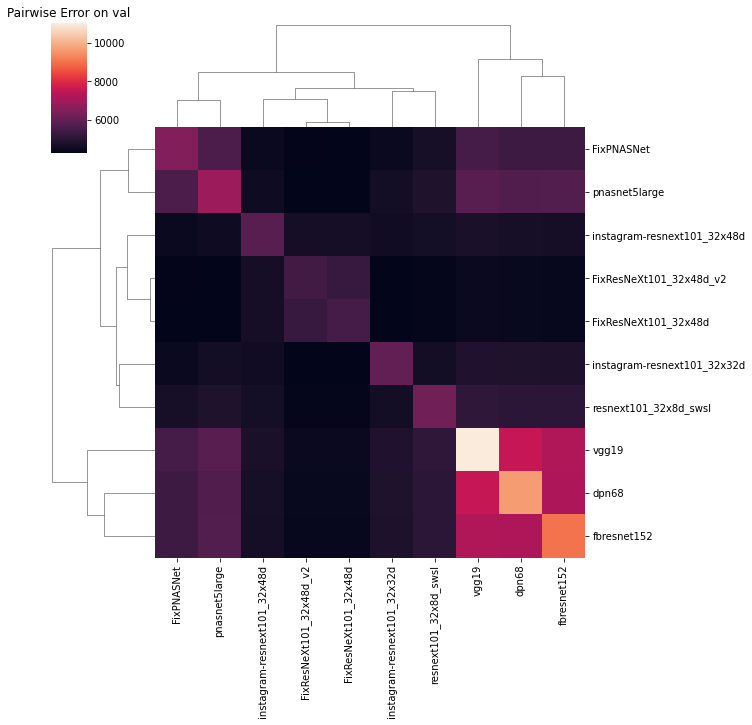

In [31]:
sns.clustermap(df_val_pairwise_error)
plt.title('Pairwise Error on val')
plt.savefig(join(logdir, 'pairwise_error_val'))
plt.show();

#### Pairwise Correlation Between Concatenated Predicted Probability Vectors

In [36]:
def create_pairwise_corr_df(eval_setting):
    pairwise_corr = defaultdict(dict)
    eval_targets = targets[eval_setting]

    for x_model, x_logits in tqdm(logits[eval_setting].items(), desc=eval_setting):
        x_train, x_test = partition(x_logits)
        
        for y_model, y_logits in logits[eval_setting].items():
            y_train, y_test = partition(y_logits)
            
            # utilize symmetric property of pairwise matrix to reduce computation
            if x_model != y_model and y_model in pairwise_corr and x_model in pairwise_corr[y_model]:
                pairwise_corr[x_model][y_model] = pairwise_corr[y_model][x_model]
            else:
                pairwise_corr[x_model][y_model] = pairwise_corrcoef(x_train, y_train)

    df = pd.DataFrame(pairwise_corr)
    styles = [dict(selector='caption', props=[('caption-side', 'top'), ("font-size", "150%")])]
    df = df.style.set_table_styles(styles).set_caption(eval_setting)
    return df.data

df_val_pairwise_corr = create_pairwise_corr_df('val')

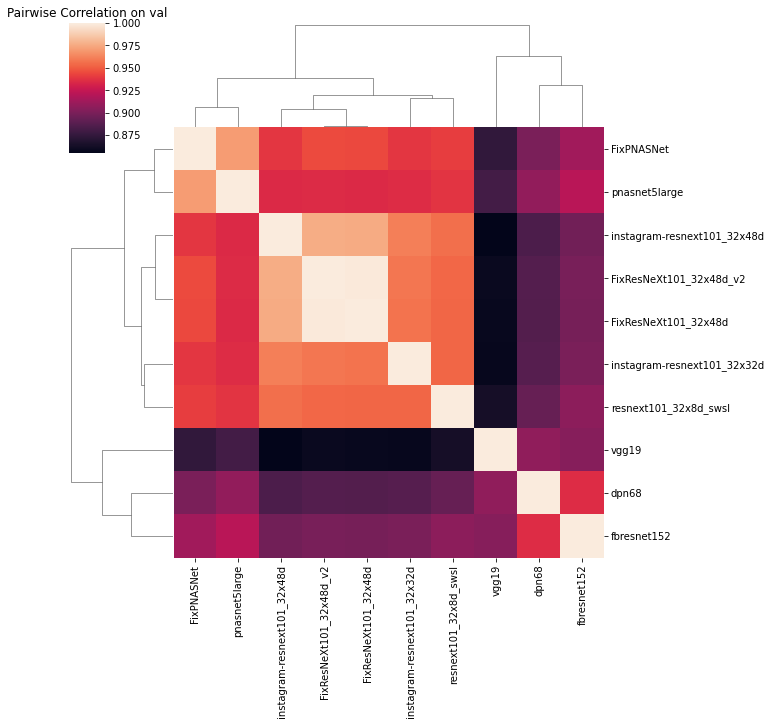

In [37]:
sns.clustermap(df_val_pairwise_corr);
plt.title('Pairwise Correlation on val')
plt.savefig(join(logdir, 'pairwise_corr_val'))
plt.show();

#### Naive Ensembling

In [38]:
def ensemble_models(models_to_ensemble):
    pred = get_pred(logits['val'][models_to_ensemble[0]])
    for model in models_to_ensemble[1:]:
        pred = torch.cat((pred, get_pred(logits['val'][model])), 0)
    return torch.mode(pred, 0, keepdim=True)[0]

# model_pred stores training predictions
model_pred = defaultdict(dict)
model_pred['val']['top5_ensemble'] = partition(ensemble_models(top5_models).flatten())[0].view(1, -1)
model_pred['val']['random5_ensemble'] = partition(ensemble_models(random5_models).flatten())[0].view(1, -1)
model_pred['val']['top5_random5_ensemble'] = partition(ensemble_models(top5_models + random5_models).flatten())[0].view(1, -1)

#### Which examples do all the models miss?


In [40]:
eval_setting = 'val'
eval_targets_train, eval_targets_test = partition(targets[eval_setting])
train_indices, test_indices = partition(np.arange(0, 50000))

for x_model, x_logits in logits[eval_setting].items():
    pred_train, pred_test = partition(get_pred(x_logits).flatten())
    model_pred[eval_setting][x_model] = pred_train.view(1, -1)
    
miss = torch.tensor([], dtype=bool)
for model, pred in model_pred[eval_setting].items():
    miss = torch.cat((miss, pred.eq(eval_targets_train.view(1, -1).expand_as(pred))))

shared_miss = [] # identify examples that all models miss    
for i in range(miss.size()[1]): # 40000 columns 
    if torch.sum(miss[:, i]) == 0:
        shared_miss.append(train_indices[i]) # map from shuffled index -> original index

print('total number of examples that all models miss:', len(shared_miss))

        
miss_freq = defaultdict(int)
for i in shared_miss:
    true_class = targets['val'][i]
    miss_freq[int(true_class)] += 1
    
miss_freq = dict(sorted(miss_freq.items(), key=lambda item: item[1], reverse=True))

total number of examples that all models miss: 2721


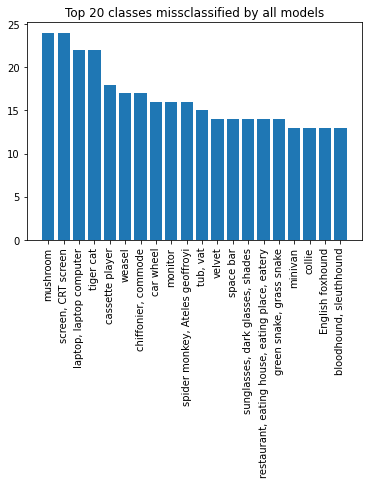

In [41]:
n = 20 # number of classes to display
plt.bar([imagenet_dict[i] for i in miss_freq.keys()][:n], list(miss_freq.values())[:n])
plt.xticks(rotation = 90)
plt.title(f'Top {n} classes missclassified by all models')
plt.savefig(join(logdir, 'top_classes_misclassified'))
plt.show();

#### Cross Class Accuracies

In [42]:
class_acc = {}
for model, pred in model_pred[eval_setting].items():
    acc = {}
    for i in np.arange(0, 1000):
        mask = (eval_targets_train == i).expand_as(model_pred[eval_setting][model])
        corr_class_pred = model_pred[eval_setting][model][mask] == i
        acc[i] = int(torch.sum(corr_class_pred)) / len(corr_class_pred)
    class_acc[model] = acc

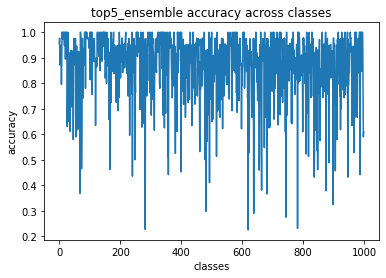

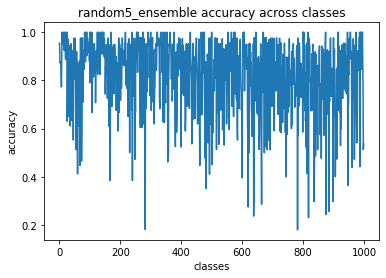

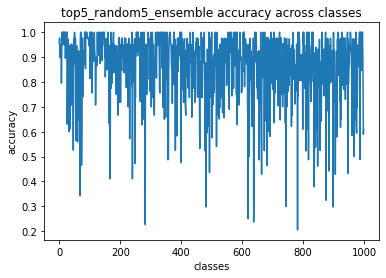

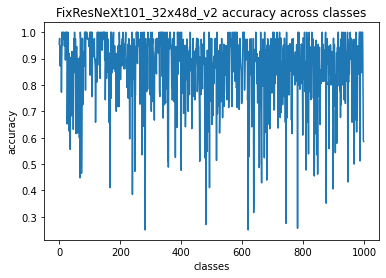

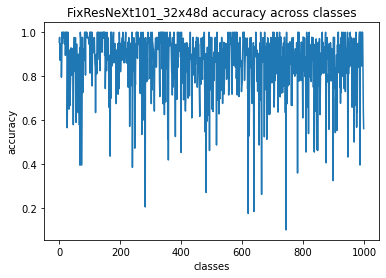

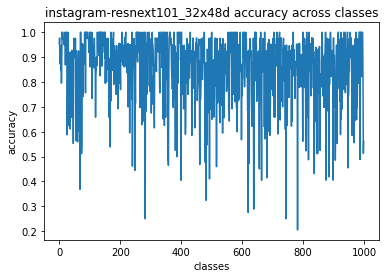

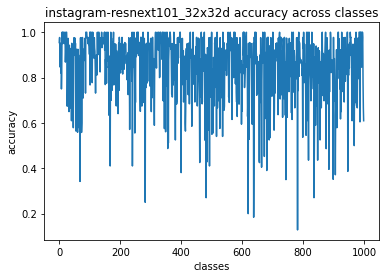

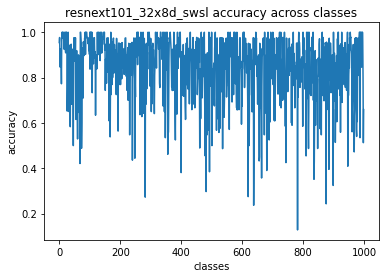

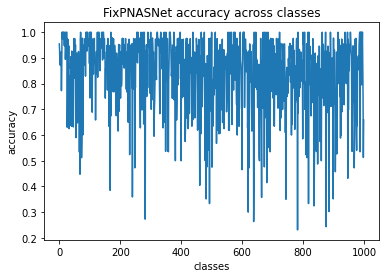

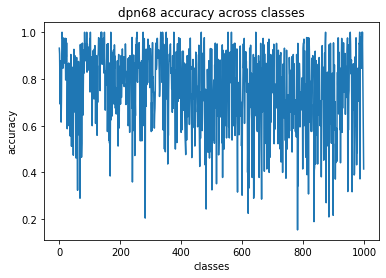

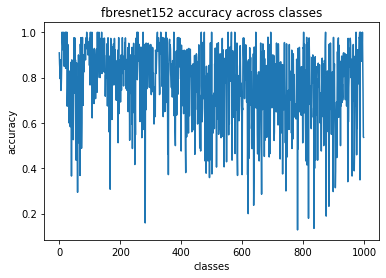

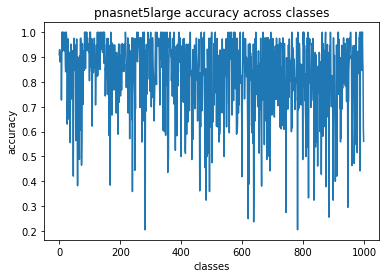

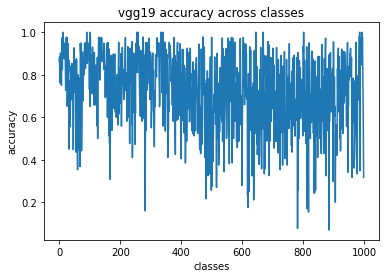

In [43]:
for model, acc in class_acc.items():
#     plt.figure(figsize=(10,7))
    plt.title(f'{model} accuracy across classes')
    plt.plot(list(acc.keys()), list(acc.values()), label=model)
    plt.xlabel('classes')
    plt.ylabel('accuracy')
    plt.savefig(join(logdir, f'{model}_cross_class_accuracy'))
    plt.show();

In [45]:
for model, pred in model_pred[eval_setting].items():
    acc = pred.eq(eval_targets_train.view(1, -1).expand_as(pred)).view(-1).float().sum() / eval_targets_train.size(0)
    print(model, acc.item())

top5_ensemble 0.8646000027656555
random5_ensemble 0.8210999965667725
top5_random5_ensemble 0.8618500232696533
FixResNeXt101_32x48d_v2 0.86285001039505
FixResNeXt101_32x48d 0.8619999885559082
instagram-resnext101_32x48d 0.8538749814033508
instagram-resnext101_32x32d 0.8500750064849854
resnext101_32x8d_swsl 0.8431000113487244
FixPNASNet 0.8365749716758728
dpn68 0.7579249739646912
fbresnet152 0.7735249996185303
pnasnet5large 0.8268250226974487
vgg19 0.7239999771118164
